In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
from subprocess import Popen, PIPE
from docx import Document
import pdfminer
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO

from docx import Document
from docx.document import Document as _Document
from docx.oxml.text.paragraph import CT_P
from docx.oxml.table import CT_Tbl
from docx.table import _Cell, Table
from docx.text.paragraph import Paragraph

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
os.getcwd()

'C:\\Users\\Shashank Shekar'

In [62]:
#os.chdir('D:\\D drive\\DataAnalytics_StudyMaterial\\IIMB-BDA\\ProjectZ\\Iteration2\\IIM')
os.chdir('D:/D drive/DataAnalytics_StudyMaterial/IIMB-BDA/ProjectZ/Iteration2/Case Writer-Applications')

In [8]:
os.getcwd()

'D:\\D drive\\DataAnalytics_StudyMaterial\\IIMB-BDA\\ProjectZ\\Iteration2\\IIM'

## Convert pdf to text

In [9]:
#Function to convert pdf to text
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)
    fp.close()
    device.close()
    str1 = retstr.getvalue()
    retstr.close()
    return str1

## Read all docx blocks

In [10]:
#Read All Docx
def iter_block_items(parent):
    """
    Generate a reference to each paragraph and table child within *parent*,
    in document order. Each returned value is an instance of either Table or
    Paragraph. *parent* would most commonly be a reference to a main
    Document object, but also works for a _Cell object, which itself can
    contain paragraphs and tables.
    """
    if isinstance(parent, _Document):
        parent_elm = parent.element.body
        # print(parent_elm.xml)
    elif isinstance(parent, _Cell):
        parent_elm = parent._tc
    else:
        raise ValueError("something's not right")

    for child in parent_elm.iterchildren():
        if isinstance(child, CT_P):
            yield Paragraph(child, parent)
        elif isinstance(child, CT_Tbl):
            yield Table(child, parent)

## Convert Document to Text including PDF - Function

In [11]:
#Function to convert doc formats (like .doc, .docx, .odt) to text
def document_to_text(filename, file_path):
    if filename[-4:] == ".doc":
        cmd = ['C:/antiword/antiword', file_path] #use antiword command
        p = Popen(cmd, stdout=PIPE)
        stdout, stderr = p.communicate()
        return stdout.decode('ascii', 'ignore')
    elif filename[-5:] == ".docx":
        doc = Document(file_path)
        fullText = []
        para_ix=0
        tbl_ix=0
        for block in iter_block_items(doc):
            block_type=block.__class__.__name__
            if block_type=='Table':
                for row in doc.tables[tbl_ix].rows:
                    for cell in row.cells:
                        for paracell in cell.paragraphs:
                            fullText.append(paracell.text)
                tbl_ix+=1
            elif block_type=='Paragraph':
                fullText.append(doc.paragraphs[para_ix].text)
                para_ix+=1
        return '\n'.join(fullText)
    elif filename[-4:] == ".odt":
        cmd = ['odt2txt', file_path]
        p = Popen(cmd, stdout=PIPE)
        stdout, stderr = p.communicate()
        return stdout.decode('ascii', 'ignore')
    elif filename[-4:] == ".pdf":
        return convert_pdf_to_txt(file_path)

## Data Cleaner

In [12]:
import pandas as pd
import re

punctuations_list = [',', '?', ':', ';', '!', ')', '(', '\'','"','*','/','<','>','{','}','[',']']

def cleanStr(mystring):
    
    # Removing non-utf charachters with space
    mystring = re.sub(r'[^\x00-\x7F]+', ' ', str(mystring).lower())
    
    for punctuation in punctuations_list:            
        mystring = mystring.replace(punctuation, "".join(punctuation).join("  "))
        
    # Replacing 2 dots with one    
    mystring = mystring.replace("..", ". ")
    
    # Removing Multiple White spaces
    message = ' '.join(mystring.split())

    return message 

In [13]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Prepare Corpus

In [14]:
os.getcwd()

'D:\\D drive\\DataAnalytics_StudyMaterial\\IIMB-BDA\\ProjectZ\\Iteration2\\IIM'

In [15]:
resume_filenames = sorted(glob.glob("*.*"))

In [16]:
print("Found Resumes:")
resume_filenames

Found Resumes:


['Abhi Kumar.docx',
 'Al Gorithm.pdf',
 'AmitBats[6_0].doc',
 'BalakrishnaReddyS[4_6].docx',
 'Bharath-Paturi-CV.pdf',
 'CURRENT_022017_Santosh kumartoleti_Resume_f0fb3c53-c308-4f86-b335-b05ebd2cccc9_SantoshkumarToleti2_6.docx',
 'CURRENT_032017_BhaktiSubhash Naik_Resume_cf61cd93-ff05-4fc4-85ec-42301b5456f5_BhaktiSubhashNaik4_9.doc',
 'CURRENT_032017_Daljeet Singh DuggalDUGGAL_Resume_adb59f9d-a2e4-46b8-abdc-375b61107dc5_DaljeetSinghDuggal6_0.docx',
 'CURRENT_032017_DishantPatel_Resume_f88c74e3-8545-4156-a708-8d093885288e_DishantPatel6_0.docx',
 'CURRENT_032017_HIRALPARMAR_Resume_3e8d6f3d-2b01-4603-8a09-12a840772afc_hiral2_0.pdf',
 'CURRENT_032017_SHALINISHALINI K_Resume_e49f1c7b-d151-44b9-9afe-b774a6852495_SHALINIK2_7.docx',
 'CURRENT_032017_SandeeV S_Resume_2cd5e682-f1f0-4d95-9483-57a25f6965c0_SandeeVS4_3.doc',
 'CURRENT_032017_SnehlataKumari_Resume_2224bb2b-a3f9-4083-9d5d-5b0a158be3fc_SnehlataKumari2_8.doc',
 'CURRENT_032017_ravisankar_Resume_f243d558-3e41-4fa6-a67d-f324fb19b2d6_ravi

In [17]:
%%time
corpus_raw = u""
for resumes in resume_filenames:
    print("Reading '{0}'...".format(resumes))
    corpus_raw+=document_to_text(resumes,os.path.join('./',resumes))
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print() 
    
    

2017-07-17 13:32:52,737 : INFO : xref found: pos=b'134706'
2017-07-17 13:32:52,739 : INFO : read_xref_from: start=134706, token=/b'xref'
2017-07-17 13:32:52,745 : INFO : xref objects: {1: (None, 134181, 0), 2: (None, 134124, 0), 3: (None, 134355, 0), 4: (None, 132013, 0), 5: (None, 131640, 0), 6: (None, 125007, 0), 7: (None, 124940, 0), 8: (None, 15, 0), 9: (None, 124973, 0), 10: (None, 308, 0), 11: (None, 7735, 0), 12: (None, 7407, 0), 13: (None, 7231, 0), 14: (None, 2961, 0), 15: (None, 6951, 0), 16: (None, 3036, 0), 17: (None, 3123, 0), 18: (None, 7432, 0), 19: (None, 39666, 0), 20: (None, 38778, 0), 21: (None, 7876, 0), 22: (None, 39045, 0), 23: (None, 67088, 0), 24: (None, 66264, 0), 25: (None, 40237, 0), 26: (None, 66537, 0), 27: (None, 91768, 0), 28: (None, 91034, 0), 29: (None, 67574, 0), 30: (None, 91315, 0), 31: (None, 113946, 0), 32: (None, 113256, 0), 33: (None, 92210, 0), 34: (None, 113534, 0), 35: (None, 114604, 0), 36: (None, 114362, 0), 37: (None, 115921, 0), 38: (None,

Reading 'Abhi Kumar.docx'...
Corpus is now 5030 characters long

Reading 'Al Gorithm.pdf'...


2017-07-17 13:32:52,863 : INFO : Pages: Kids=[<PDFObjRef:6>]
2017-07-17 13:32:52,868 : INFO : Page: {'Type': /'Page', 'CropBox': [0, 0, 612, 792], 'MediaBox': [0, 0, 612, 792], 'Resources': {'ColorSpace': {'CS0': <PDFObjRef:7>, 'CS1': <PDFObjRef:9>}, 'Font': {'C2_0': <PDFObjRef:11>, 'TT0': <PDFObjRef:19>, 'TT1': <PDFObjRef:23>, 'TT2': <PDFObjRef:27>, 'TT3': <PDFObjRef:31>, 'TT4': <PDFObjRef:35>}}, 'Annots': [<PDFObjRef:37>], 'Contents': <PDFObjRef:44>, 'StructParents': 1, 'Tabs': /'S', 'Parent': <PDFObjRef:2>}
2017-07-17 13:32:52,872 : INFO : Processing page: <PDFPage: Resources={'ColorSpace': {'CS0': <PDFObjRef:7>, 'CS1': <PDFObjRef:9>}, 'Font': {'C2_0': <PDFObjRef:11>, 'TT0': <PDFObjRef:19>, 'TT1': <PDFObjRef:23>, 'TT2': <PDFObjRef:27>, 'TT3': <PDFObjRef:31>, 'TT4': <PDFObjRef:35>}}, MediaBox=[0, 0, 612, 792]>
2017-07-17 13:32:52,874 : INFO : render_contents: resources={'ColorSpace': {'CS0': <PDFObjRef:7>, 'CS1': <PDFObjRef:9>}, 'Font': {'C2_0': <PDFObjRef:11>, 'TT0': <PDFObjRef:19>,

Corpus is now 7315 characters long

Reading 'AmitBats[6_0].doc'...
Corpus is now 21748 characters long

Reading 'BalakrishnaReddyS[4_6].docx'...
Corpus is now 30230 characters long

Reading 'Bharath-Paturi-CV.pdf'...


2017-07-17 13:32:53,982 : INFO : trailer: {'Size': 171, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:145>, 'ID': [b'\x0e\x1d\xc1\xc1\xfb\xd0\xbbF\x9c\xac\xa0\xdb\xf4\xa2\xc4\xad', b'\x0e\x1d\xc1\xc1\xfb\xd0\xbbF\x9c\xac\xa0\xdb\xf4\xa2\xc4\xad']}
2017-07-17 13:32:53,987 : INFO : Pages: Kids=[<PDFObjRef:3>]
2017-07-17 13:32:53,991 : INFO : Page: {'Type': /'Page', 'Parent': <PDFObjRef:2>, 'Resources': {'ExtGState': {'GS5': <PDFObjRef:5>, 'GS6': <PDFObjRef:6>}, 'Font': {'F1': <PDFObjRef:7>, 'F2': <PDFObjRef:9>, 'F3': <PDFObjRef:11>, 'F4': <PDFObjRef:14>, 'F5': <PDFObjRef:16>, 'F6': <PDFObjRef:18>, 'F7': <PDFObjRef:20>, 'F8': <PDFObjRef:22>, 'F9': <PDFObjRef:27>, 'F10': <PDFObjRef:32>, 'F11': <PDFObjRef:37>}, 'ProcSet': [/'PDF', /'Text', /'ImageB', /'ImageC', /'ImageI']}, 'Annots': [<PDFObjRef:13>], 'MediaBox': [0, 0, 596.04, 842.04], 'Contents': <PDFObjRef:4>, 'Group': {'Type': /'Group', 'S': /'Transparency', 'CS': /'DeviceRGB'}, 'Tabs': /'S', 'StructParents': 0}
2017-07-17 13:32:53,996 : IN

Corpus is now 32452 characters long

Reading 'CURRENT_022017_Santosh kumartoleti_Resume_f0fb3c53-c308-4f86-b335-b05ebd2cccc9_SantoshkumarToleti2_6.docx'...
Corpus is now 39067 characters long

Reading 'CURRENT_032017_BhaktiSubhash Naik_Resume_cf61cd93-ff05-4fc4-85ec-42301b5456f5_BhaktiSubhashNaik4_9.doc'...
Corpus is now 42613 characters long

Reading 'CURRENT_032017_Daljeet Singh DuggalDUGGAL_Resume_adb59f9d-a2e4-46b8-abdc-375b61107dc5_DaljeetSinghDuggal6_0.docx'...


2017-07-17 13:32:55,227 : INFO : xref found: pos=b'30654'
2017-07-17 13:32:55,229 : INFO : read_xref_from: start=30654, token=/b'xref'
2017-07-17 13:32:55,231 : INFO : xref objects: {1: (None, 9, 0), 2: (None, 30549, 0), 3: (None, 167, 0), 4: (None, 262, 0), 5: (None, 609, 0), 6: (None, 30407, 0), 7: (None, 13844, 0), 8: (None, 299, 0), 9: (None, 350, 0), 10: (None, 401, 0), 11: (None, 453, 0), 12: (None, 505, 0), 13: (None, 557, 0), 14: (None, 19575, 0), 15: (None, 938, 0), 16: (None, 6315, 0), 17: (None, 730, 0), 18: (None, 918, 0), 19: (None, 8370, 0), 20: (None, 6336, 0), 21: (None, 6388, 0), 22: (None, 6440, 0), 23: (None, 6492, 0), 24: (None, 6544, 0), 25: (None, 8203, 0), 26: (None, 8065, 0), 27: (None, 6774, 0), 28: (None, 7184, 0), 29: (None, 7358, 0), 30: (None, 7654, 0), 31: (None, 7816, 0), 32: (None, 7947, 0), 33: (None, 6886, 0), 34: (None, 7034, 0), 35: (None, 7499, 0), 36: (None, 8266, 0), 37: (None, 8690, 0), 38: (None, 9864, 0), 39: (None, 8492, 0), 40: (None, 8670, 0

Corpus is now 50218 characters long

Reading 'CURRENT_032017_DishantPatel_Resume_f88c74e3-8545-4156-a708-8d093885288e_DishantPatel6_0.docx'...
Corpus is now 58023 characters long

Reading 'CURRENT_032017_HIRALPARMAR_Resume_3e8d6f3d-2b01-4603-8a09-12a840772afc_hiral2_0.pdf'...


2017-07-17 13:32:55,276 : INFO : trailer: {'Size': 56, 'Info': <PDFObjRef:1>, 'Root': <PDFObjRef:36>}
2017-07-17 13:32:55,280 : INFO : Pages: Kids=[<PDFObjRef:5>, <PDFObjRef:19>]
2017-07-17 13:32:55,282 : INFO : Page: {'Type': /'Page', 'Parent': <PDFObjRef:2>, 'Contents': <PDFObjRef:15>, 'Resources': <PDFObjRef:17>, 'Annots': <PDFObjRef:18>, 'MediaBox': [0, 0, 595, 842]}
2017-07-17 13:32:55,288 : INFO : Processing page: <PDFPage: Resources={'ColorSpace': {'PCSp': <PDFObjRef:4>, 'CSp': /'DeviceRGB', 'CSpg': /'DeviceGray'}, 'ExtGState': {'GSa': <PDFObjRef:3>}, 'Pattern': {}, 'Font': {'F6': <PDFObjRef:6>, 'F7': <PDFObjRef:7>, 'F14': <PDFObjRef:14>}, 'XObject': {}}, MediaBox=[0, 0, 595, 842]>
2017-07-17 13:32:55,290 : INFO : render_contents: resources={'ColorSpace': {'PCSp': <PDFObjRef:4>, 'CSp': /'DeviceRGB', 'CSpg': /'DeviceGray'}, 'ExtGState': {'GSa': <PDFObjRef:3>}, 'Pattern': {}, 'Font': {'F6': <PDFObjRef:6>, 'F7': <PDFObjRef:7>, 'F14': <PDFObjRef:14>}, 'XObject': {}}, streams=[<PDFSt

Corpus is now 60740 characters long

Reading 'CURRENT_032017_SHALINISHALINI K_Resume_e49f1c7b-d151-44b9-9afe-b774a6852495_SHALINIK2_7.docx'...
Corpus is now 66299 characters long

Reading 'CURRENT_032017_SandeeV S_Resume_2cd5e682-f1f0-4d95-9483-57a25f6965c0_SandeeVS4_3.doc'...
Corpus is now 84716 characters long

Reading 'CURRENT_032017_SnehlataKumari_Resume_2224bb2b-a3f9-4083-9d5d-5b0a158be3fc_SnehlataKumari2_8.doc'...
Corpus is now 89130 characters long

Reading 'CURRENT_032017_ravisankar_Resume_f243d558-3e41-4fa6-a67d-f324fb19b2d6_ravisankar4_5.doc'...
Corpus is now 99432 characters long

Reading 'CURRENT_032017_umashankar_Resume_77f65cee-4bce-4d83-9103-cc47c019eb96_umashankar11_0 (1).doc'...
Corpus is now 107648 characters long

Reading 'CURRENT_032017_yerramanenikoteswararao_Resume_560553c9-3c04-49c3-8702-a53b153ddb22_yerramanenikoteswararao5_2.docx'...
Corpus is now 116296 characters long

Reading 'CURRENT_042017_KARANVIRSINGH_Resume_24452b3d-e135-415d-b99e-a7c8a40d8891_KaranvirS

2017-07-17 13:32:57,333 : INFO : xref found: pos=b'127015'
2017-07-17 13:32:57,334 : INFO : read_xref_from: start=127015, token=/b'xref'
2017-07-17 13:32:57,337 : INFO : xref objects: {1: (None, 124760, 0), 2: (None, 19, 0), 3: (None, 4224, 0), 4: (None, 124903, 0), 5: (None, 4245, 0), 6: (None, 8567, 0), 7: (None, 126505, 0), 8: (None, 8588, 0), 9: (None, 10110, 0), 10: (None, 10131, 0), 11: (None, 10322, 0), 12: (None, 10614, 0), 13: (None, 10775, 0), 14: (None, 27091, 0), 15: (None, 27114, 0), 16: (None, 27329, 0), 17: (None, 27750, 0), 18: (None, 28042, 0), 19: (None, 56726, 0), 20: (None, 56749, 0), 21: (None, 56955, 0), 22: (None, 57521, 0), 23: (None, 57939, 0), 24: (None, 90808, 0), 25: (None, 90831, 0), 26: (None, 91032, 0), 27: (None, 91637, 0), 28: (None, 92086, 0), 29: (None, 122333, 0), 30: (None, 122356, 0), 31: (None, 122545, 0), 32: (None, 123592, 0), 33: (None, 124632, 0), 34: (None, 124705, 0), 35: (None, 125046, 0), 36: (None, 125102, 0), 37: (None, 125226, 0), 38: (

Corpus is now 157369 characters long

Reading 'CURRENT_052017_HarikrishnaPalla_Resume_0b50617e-97f1-4b22-94c1-0fa51548daa2_harikrishnapalla5_0.doc'...
Corpus is now 163491 characters long

Reading 'CURRENT_052017_LaliteshUpadhyaya_Resume_9db2850b-a607-4a84-899d-1b0f9a0a8459_LaliteshUpadhyaya4_6.docx'...
Corpus is now 169581 characters long

Reading 'CURRENT_052017_NISHTHASHRIVASTAVA_Resume_c162f248-0fd9-4c0c-97b0-c22782d9cba1_NISHTHASHRIVASTAVA2_1.docx'...
Corpus is now 173687 characters long

Reading 'CURRENT_052017_PHANI TEJAYELLAPRAGADA VISAKHA_Resume_a72368b8-befc-4686-afdf-e2cf26735238_PhaniTeja3_5.docx'...
Corpus is now 175714 characters long

Reading 'CURRENT_052017_RagunathanAnnadurai_Resume_3a1aca2d-751e-45b8-8975-69a310116353_RagunathanAnnadurai3_6.docx'...
Corpus is now 178997 characters long

Reading 'CURRENT_052017_SAIKUMARKADA_Resume_a80bc2c6-71f8-4336-b4d9-7a8de2899966_KSaiKumar4_2.pdf'...


2017-07-17 13:32:57,409 : INFO : trailer: {'Size': 46, 'Root': <PDFObjRef:44>, 'Info': <PDFObjRef:45>, 'ID': [b'\r\x848\xb8\xfc\x92=\xd7\xbe\xdb\x18j\x95{t\xae', b'\r\x848\xb8\xfc\x92=\xd7\xbe\xdb\x18j\x95{t\xae'], 'DocChecksum': /'84A88A57F84CCBA95D4B7E6F1914C612'}
2017-07-17 13:32:57,416 : INFO : Pages: Kids=[<PDFObjRef:1>, <PDFObjRef:4>]
2017-07-17 13:32:57,420 : INFO : Page: {'Type': /'Page', 'Parent': <PDFObjRef:7>, 'Resources': <PDFObjRef:34>, 'MediaBox': [0, 0, 612, 792], 'Group': {'S': /'Transparency', 'CS': /'DeviceRGB', 'I': True}, 'Contents': <PDFObjRef:2>}
2017-07-17 13:32:57,423 : INFO : Processing page: <PDFPage: Resources={'Font': <PDFObjRef:33>, 'ProcSet': [/'PDF', /'Text']}, MediaBox=[0, 0, 612, 792]>
2017-07-17 13:32:57,424 : INFO : render_contents: resources={'Font': <PDFObjRef:33>, 'ProcSet': [/'PDF', /'Text']}, streams=[<PDFStream(2): raw=4135, {'Length': <PDFObjRef:3>, 'Filter': /'FlateDecode'}>], ctm=(1, 0, 0, 1, 0, 0)
2017-07-17 13:32:57,432 : INFO : get_font: c

Corpus is now 184516 characters long

Reading 'CURRENT_052017_SaradhiPoluru_Resume_96f4e1db-a0b4-4d86-b78a-15737964766e_Saradhi3_3.docx'...
Corpus is now 192693 characters long

Reading 'CURRENT_052017_SaranSaran Kumar_Resume_3fa61230-f101-46b3-9cc4-b64192da89fd_SaranKumar4_0.doc'...
Corpus is now 203097 characters long

Reading 'CURRENT_052017_Shaikh ShadmaWarsi_Resume_af9ac017-9ce8-4e1b-b6c9-73d21feb820d_ShaikhShadmaWarsi3_3.docx'...
Corpus is now 212527 characters long

Reading 'CURRENT_052017_VIVEK KUMAR REDDYMUDUGANTI_Resume_f9d5afc7-1ddc-4702-9a6e-d6775cf9f68f_VivekReddy3_0.doc'...
Corpus is now 221238 characters long

Reading 'CURRENT_052017_YeshasMandya Devaraju_Resume_3fbd57d9-cd9e-4d75-bfad-38f1c526b427_YeshasMD4_3.docx'...
Corpus is now 226703 characters long

Reading 'CURRENT_052017_lakshmiprasad_Resume_1111a5b8-bac2-4e92-97f7-12ac4ea82ca4_lakshmiprasad4_0.doc'...
Corpus is now 235039 characters long

Reading 'CURRENT_052017_usharani_Resume_651d8412-2f0a-4908-a641-2c802d432

2017-07-17 13:32:59,287 : INFO : xref found: pos=b'62251'
2017-07-17 13:32:59,289 : INFO : read_xref_from: start=62251, token=/b'xref'
2017-07-17 13:32:59,292 : INFO : xref objects: {1: (None, 61708, 0), 2: (None, 61593, 0), 3: (None, 61900, 0), 4: (None, 59481, 0), 5: (None, 59108, 0), 6: (None, 52787, 0), 7: (None, 56617, 0), 8: (None, 15, 0), 9: (None, 56694, 0), 10: (None, 70, 0), 11: (None, 56832, 0), 12: (None, 126, 0), 13: (None, 56925, 0), 14: (None, 182, 0), 15: (None, 57024, 0), 16: (None, 238, 0), 17: (None, 57124, 0), 18: (None, 294, 0), 19: (None, 57243, 0), 20: (None, 350, 0), 21: (None, 57335, 0), 22: (None, 406, 0), 23: (None, 57460, 0), 24: (None, 462, 0), 25: (None, 52752, 0), 26: (None, 518, 0), 27: (None, 32602, 0), 28: (None, 31714, 0), 29: (None, 812, 0), 30: (None, 31981, 0), 31: (None, 33441, 0), 32: (None, 33173, 0), 33: (None, 34909, 0), 34: (None, 34647, 0), 35: (None, 36376, 0), 36: (None, 36105, 0), 37: (None, 37826, 0), 38: (None, 37577, 0), 39: (None, 390

Corpus is now 274610 characters long

Reading 'John Paul.docx'...
Corpus is now 283692 characters long

Reading 'Joy Charlotte.docx'...
Corpus is now 293175 characters long

Reading 'MACK CROLANGUAGE.pdf'...


2017-07-17 13:32:59,423 : INFO : trailer: {'Size': 138, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:3>, 'ID': [b"\xe5'\xfcNR*\xab_\x02~\x89j>\x06u'", b'<^VD\xa9%\xfem\x80\x1a(e\x952R(']}
2017-07-17 13:32:59,428 : INFO : Pages: Kids=[<PDFObjRef:6>]
2017-07-17 13:32:59,431 : INFO : Page: {'Type': /'Page', 'CropBox': [0, 0, 612, 792], 'MediaBox': [0, 0, 612, 792], 'Resources': {'ColorSpace': {'CS0': <PDFObjRef:25>}, 'Font': {'TT0': <PDFObjRef:27>, 'TT1': <PDFObjRef:31>, 'TT2': <PDFObjRef:33>, 'TT3': <PDFObjRef:35>, 'TT4': <PDFObjRef:37>}}, 'Contents': <PDFObjRef:39>, 'StructParents': 0, 'Tabs': /'S', 'Parent': <PDFObjRef:2>}
2017-07-17 13:32:59,435 : INFO : Processing page: <PDFPage: Resources={'ColorSpace': {'CS0': <PDFObjRef:25>}, 'Font': {'TT0': <PDFObjRef:27>, 'TT1': <PDFObjRef:31>, 'TT2': <PDFObjRef:33>, 'TT3': <PDFObjRef:35>, 'TT4': <PDFObjRef:37>}}, MediaBox=[0, 0, 612, 792]>
2017-07-17 13:32:59,436 : INFO : render_contents: resources={'ColorSpace': {'CS0': <PDFObjRef:25>}, 'Font': {

Corpus is now 296271 characters long

Reading 'Mohit Patra.docx'...
Corpus is now 309150 characters long

Reading 'Munish-Kaushik - 2017.docx'...
Corpus is now 318916 characters long

Reading 'N Y Patil.docx'...
Corpus is now 330277 characters long

Reading 'NagendraSwami[2_0].docx'...
Corpus is now 347643 characters long

Reading 'PrasannaKumar.docx'...
Corpus is now 364405 characters long

Reading 'Raj Malhotra.docx'...
Corpus is now 375775 characters long

Reading 'RajashekharaiahM[4_0].docx'...
Corpus is now 386463 characters long

Reading 'Rajesh[6_0].docx'...


2017-07-17 13:33:01,574 : INFO : xref found: pos=b'271869'
2017-07-17 13:33:01,576 : INFO : read_xref_from: start=271869, token=/b'xref'
2017-07-17 13:33:01,578 : INFO : xref objects: {}
2017-07-17 13:33:01,581 : INFO : trailer: {'Size': 337, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:53>, 'ID': [b'\xf8\xce\x13\xb2?@hH\x8a\xf0\x1c\x85\xe4\xab\xa9,', b'\xf8\xce\x13\xb2?@hH\x8a\xf0\x1c\x85\xe4\xab\xa9,'], 'Prev': 264969, 'XRefStm': 264040}
2017-07-17 13:33:01,582 : INFO : read_xref_from: start=264040, token=336
2017-07-17 13:33:01,585 : INFO : xref stream: objid=(0, 336), fields=1,4,2


Corpus is now 397718 characters long

Reading 'RohitKhanna.docx'...
Corpus is now 399706 characters long

Reading 'SARANJITH KRISHNAN.docx'...
Corpus is now 415229 characters long

Reading 'SWETA[2_11].pdf'...


2017-07-17 13:33:01,587 : INFO : trailer: {'Type': /'XRef', 'Size': 336, 'W': [1, 4, 2], 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:53>, 'ID': [b'\xf8\xce\x13\xb2?@hH\x8a\xf0\x1c\x85\xe4\xab\xa9,', b'\xf8\xce\x13\xb2?@hH\x8a\xf0\x1c\x85\xe4\xab\xa9,'], 'Filter': /'FlateDecode', 'Length': 726}
2017-07-17 13:33:01,593 : INFO : read_xref_from: start=264969, token=/b'xref'
2017-07-17 13:33:01,602 : INFO : xref objects: {1: (None, 17, 0), 2: (None, 168, 0), 3: (None, 252, 0), 4: (None, 535, 0), 5: (None, 1199, 0), 6: (None, 1368, 0), 7: (None, 1608, 0), 8: (None, 1661, 0), 9: (None, 1714, 0), 10: (None, 1892, 0), 11: (None, 2134, 0), 12: (None, 2308, 0), 13: (None, 2545, 0), 14: (None, 2917, 0), 15: (None, 8287, 0), 16: (None, 8486, 0), 17: (None, 8689, 0), 18: (None, 8852, 0), 19: (None, 9079, 0), 20: (None, 9278, 0), 21: (None, 9481, 0), 22: (None, 9680, 0), 23: (None, 9887, 0), 24: (None, 10056, 0), 25: (None, 10288, 0), 26: (None, 10421, 0), 27: (None, 10451, 0), 28: (None, 10612, 0), 29

Corpus is now 419751 characters long

Reading 'Sahib Singh.docx'...
Corpus is now 435690 characters long

Reading 'Sam Vinay.docx'...
Corpus is now 449194 characters long

Reading 'Shwetarathore[5_0].docx'...
Corpus is now 461985 characters long

Reading 'Sumit Shastry.docx'...


2017-07-17 13:33:04,364 : INFO : xref found: pos=b'161167'
2017-07-17 13:33:04,365 : INFO : read_xref_from: start=161167, token=/b'xref'
2017-07-17 13:33:04,367 : INFO : xref objects: {}
2017-07-17 13:33:04,369 : INFO : trailer: {'Size': 430, 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:49>, 'ID': [b'\xb1E\x02\xd0\xa3\xa0\xa8E\xbdi\x110\xa8\xd3W$', b'\xb1E\x02\xd0\xa3\xa0\xa8E\xbdi\x110\xa8\xd3W$'], 'Prev': 152407, 'XRefStm': 151254}


Corpus is now 474444 characters long

Reading 'Sundar Rajan.docx'...
Corpus is now 487714 characters long

Reading 'Sunil Kumar Petluri1.pdf'...


2017-07-17 13:33:04,371 : INFO : read_xref_from: start=151254, token=429
2017-07-17 13:33:04,375 : INFO : xref stream: objid=(0, 429), fields=1,4,2
2017-07-17 13:33:04,377 : INFO : trailer: {'Type': /'XRef', 'Size': 429, 'W': [1, 4, 2], 'Root': <PDFObjRef:1>, 'Info': <PDFObjRef:49>, 'ID': [b'\xb1E\x02\xd0\xa3\xa0\xa8E\xbdi\x110\xa8\xd3W$', b'\xb1E\x02\xd0\xa3\xa0\xa8E\xbdi\x110\xa8\xd3W$'], 'Filter': /'FlateDecode', 'Length': 950}
2017-07-17 13:33:04,378 : INFO : read_xref_from: start=152407, token=/b'xref'
2017-07-17 13:33:04,386 : INFO : xref objects: {1: (None, 17, 0), 2: (None, 184, 0), 3: (None, 268, 0), 4: (None, 605, 0), 5: (None, 6036, 0), 6: (None, 6218, 0), 7: (None, 6486, 0), 8: (None, 6539, 0), 9: (None, 6592, 0), 10: (None, 6779, 0), 11: (None, 7041, 0), 12: (None, 7218, 0), 13: (None, 7477, 0), 14: (None, 7634, 0), 15: (None, 7815, 0), 16: (None, 7942, 0), 17: (None, 7972, 0), 18: (None, 8127, 0), 19: (None, 8201, 0), 20: (None, 8434, 0), 21: (None, 8597, 0), 22: (None, 8

Corpus is now 500881 characters long

Reading 'VNPoornimaDeviS[4_7].docx'...
Corpus is now 507873 characters long

Reading 'Venkatesh[4_1].doc'...
Corpus is now 513963 characters long

Reading 'Victor Frankfurt.docx'...
Corpus is now 527979 characters long

Reading 'kishorekumar.docx'...
Corpus is now 531399 characters long

Reading 'punitSingh.docx'...
Corpus is now 534980 characters long

Reading '~$nkatesh[4_1].doc'...
Corpus is now 534980 characters long

Wall time: 14.5 s


In [18]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [19]:
raw_sentences = tokenizer.tokenize(corpus_raw)

## Cleanup - preprocessing

In [20]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
punctuations_list = [',', '?', ':', ';', '!', ')', '(', '\'','"','*','/','<','>','{','}','[',']']

In [21]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    for punctuation in punctuations_list:            
        raw = raw.replace(punctuation, " ")
    clean1 = re.sub("\|"," ", raw)
    clean2 = re.sub("\r\n"," ",clean1)
    clean3 = re.sub("\t", " ", clean2)
    clean4 = re.sub("\n", " ", clean3)
    clean5 = cleanStr(clean4)
    clean6 = clean5.lower().split()
    words=[w for w in clean6 if w not in stop_words]
    return words



In [22]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [23]:
print(raw_sentences[1])
print(sentence_to_wordlist(raw_sentences[1]))

• Currently working with Teradata (V2R5 & 12) and created and manipulated many scripts in BTEQ, FastLoad, MultiLoad, FastExport, and Tpump.
['currently', 'working', 'teradata', 'v2r5', '&', '12', 'created', 'manipulated', 'many', 'scripts', 'bteq', 'fastload', 'multiload', 'fastexport', 'tpump.']


In [24]:
token_count = sum([len(sentence) for sentence in sentences])
print("The resumes corpus contains {0:,} tokens".format(token_count))

The resumes corpus contains 54,433 tokens


In [25]:
multiprocessing.cpu_count()

4

## Train Word2Vec

In [26]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 500
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 4

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

token_count = sum([len(sentence) for sentence in sentences])

In [27]:
res2vec=w2v.Word2Vec(sg=1,seed=seed,workers=num_workers,size=num_features,min_count=min_word_count,window=context_size,sample=downsampling)

In [28]:
%%time
res2vec.build_vocab(sentences)

2017-07-17 13:34:37,328 : INFO : collecting all words and their counts
2017-07-17 13:34:37,331 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-07-17 13:34:37,361 : INFO : collected 8753 word types from a corpus of 54433 raw words and 4069 sentences
2017-07-17 13:34:37,363 : INFO : Loading a fresh vocabulary
2017-07-17 13:34:37,382 : INFO : min_count=3 retains 3028 unique words (34% of original 8753, drops 5725)
2017-07-17 13:34:37,384 : INFO : min_count=3 leaves 47306 word corpus (86% of original 54433, drops 7127)
2017-07-17 13:34:37,407 : INFO : deleting the raw counts dictionary of 8753 items
2017-07-17 13:34:37,410 : INFO : sample=0.001 downsamples 45 most-common words
2017-07-17 13:34:37,412 : INFO : downsampling leaves estimated 43355 word corpus (91.6% of prior 47306)
2017-07-17 13:34:37,414 : INFO : estimated required memory for 3028 words and 500 dimensions: 13626000 bytes
2017-07-17 13:34:37,432 : INFO : resetting layer weights


Wall time: 242 ms


In [29]:
print("Word2Vec vocabulary length:", len(res2vec.wv.vocab))

Word2Vec vocabulary length: 3028


## Start Training

In [30]:
%%time
res2vec.train(sentences,total_examples = token_count,epochs = res2vec.iter )

2017-07-17 13:38:44,198 : INFO : training model with 4 workers on 3028 vocabulary and 500 features, using sg=1 hs=0 sample=0.001 negative=5 window=4
2017-07-17 13:38:45,313 : INFO : PROGRESS: at 3.58% examples, 101720 words/s, in_qsize 7, out_qsize 0
2017-07-17 13:38:45,929 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-07-17 13:38:45,964 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-07-17 13:38:45,978 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-07-17 13:38:46,031 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-07-17 13:38:46,033 : INFO : training on 272165 raw words (216704 effective words) took 1.7s, 124900 effective words/s
2017-07-17 13:38:46,035 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2017-07-17 13:38:46,037 : WARNING : supplied example count (20345) did not equal expected count (272165)


Wall time: 1.84 s


216704

In [31]:
#res2vec.save(os.path.join('../res2vecModCntntWriter2CBOW.w2v'))
res2vec.save(os.path.join('../res2vecModITDomain4SG.w2v'))

2017-07-17 13:42:05,444 : INFO : saving Word2Vec object under ../res2vecModITDomain4SG.w2v, separately None
2017-07-17 13:42:05,447 : INFO : not storing attribute syn0norm
2017-07-17 13:42:05,450 : INFO : not storing attribute cum_table
2017-07-17 13:42:05,702 : INFO : saved ../res2vecModITDomain4SG.w2v


In [63]:
res2vec = w2v.Word2Vec.load(os.path.join('res2vecModCntntWriter2CBOW.w2v'))
#res2vec = w2v.Word2Vec.load(os.path.join('../res2vecModITDomain4CBOW.w2v'))
#res2vec = w2v.Word2Vec.load(os.path.join('../res2vecModITDomain4SG.w2v'))

2017-07-17 16:06:45,222 : INFO : loading Word2Vec object from res2vecModCntntWriter2CBOW.w2v
2017-07-17 16:06:45,790 : INFO : loading wv recursively from res2vecModCntntWriter2CBOW.w2v.wv.* with mmap=None
2017-07-17 16:06:45,792 : INFO : setting ignored attribute syn0norm to None
2017-07-17 16:06:45,794 : INFO : setting ignored attribute cum_table to None
2017-07-17 16:06:45,796 : INFO : loaded res2vecModCntntWriter2CBOW.w2v


In [64]:
number_words = len(res2vec.wv.vocab)
print(number_words)

3799


In [61]:
#res2vec.wv.vocab
res2vec.wv.most_similar(positive=[], negative=['requirement'], topn=10)

[('eclipse', -0.06732383370399475),
 ('tomcat', -0.07058249413967133),
 ('languages', -0.07854612171649933),
 ('windows', -0.08982990682125092),
 ('xp', -0.09790933132171631),
 ('server', -0.09910985082387924),
 ('10g', -0.1020645797252655),
 ('mysql', -0.10852152109146118),
 ('6', -0.11466915160417557),
 ('2000', -0.12427083402872086)]

In [164]:
list(res2vec.wv.vocab.items())[0][0]

'resume'

## Test Model

In [112]:
%%time
os.chdir('D:/D drive/DataAnalytics_StudyMaterial/IIMB-BDA/ProjectZ/Iteration2/Case Writer-Applications/TestData')
resume_filenames_test = sorted(glob.glob("*.*"))

corpus_raw_test = u""
for resumes in resume_filenames_test:
    print("Reading '{0}'...".format(resumes))
    corpus_raw_test+=document_to_text(resumes,os.path.join('./',resumes))
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print() 
    

2017-07-01 18:59:39,886 : INFO : xref found: pos=b'116'
2017-07-01 18:59:39,888 : INFO : read_xref_from: start=116, token=162
2017-07-01 18:59:39,893 : INFO : xref stream: objid=(146, 31), fields=1,2,1
2017-07-01 18:59:39,895 : INFO : trailer: {'DecodeParms': {'Columns': 4, 'Predictor': 12}, 'Filter': /'FlateDecode', 'ID': [b'#y\x94~<\x14\xddE\x8a\xf9>{\xdd\t\xce,', b'\x8b\xf8\x00\x80\x9f\xe05M\x9e\x00\xdc*G\xbf\x8c\xf6'], 'Index': [146, 31], 'Info': <PDFObjRef:145>, 'Length': 82, 'Prev': 26967, 'Root': <PDFObjRef:147>, 'Size': 177, 'Type': /'XRef', 'W': [1, 2, 1]}
2017-07-01 18:59:39,897 : INFO : read_xref_from: start=26967, token=10
2017-07-01 18:59:39,902 : INFO : xref stream: objid=(0, 146), fields=1,2,1
2017-07-01 18:59:39,904 : INFO : trailer: {'DecodeParms': {'Columns': 4, 'Predictor': 12}, 'Filter': /'FlateDecode', 'ID': [b'#y\x94~<\x14\xddE\x8a\xf9>{\xdd\t\xce,', b'\x8b\xf8\x00\x80\x9f\xe05M\x9e\x00\xdc*G\xbf\x8c\xf6'], 'Info': <PDFObjRef:145>, 'Length': 74, 'Root': <PDFObjRef

Reading 'AnitaGanguli_363321_-15_-_1.docx'...
Corpus is now 686294 characters long

Reading 'AnumehaVerma_362785_-07_00-_1.pdf'...


2017-07-01 18:59:40,113 : INFO : Pages: Kids=[<PDFObjRef:148>, <PDFObjRef:1>]
2017-07-01 18:59:40,125 : INFO : Page: {'Contents': [<PDFObjRef:150>, <PDFObjRef:151>, <PDFObjRef:152>, <PDFObjRef:153>, <PDFObjRef:154>, <PDFObjRef:155>, <PDFObjRef:156>, <PDFObjRef:158>], 'CropBox': [0.0, 0.0, 595.32, 841.92], 'Group': <PDFObjRef:175>, 'MediaBox': [0.0, 0.0, 595.32, 841.92], 'Parent': <PDFObjRef:144>, 'Resources': {'ColorSpace': {'CS0': <PDFObjRef:163>, 'CS1': <PDFObjRef:164>, 'CS2': <PDFObjRef:163>}, 'ExtGState': {'GS0': <PDFObjRef:165>}, 'Font': {'TT0': <PDFObjRef:167>, 'TT1': <PDFObjRef:169>, 'TT2': <PDFObjRef:171>, 'TT3': <PDFObjRef:173>}, 'XObject': {'Im0': <PDFObjRef:157>, 'Im1': <PDFObjRef:157>, 'Im10': <PDFObjRef:157>, 'Im11': <PDFObjRef:157>, 'Im12': <PDFObjRef:157>, 'Im13': <PDFObjRef:157>, 'Im14': <PDFObjRef:157>, 'Im15': <PDFObjRef:157>, 'Im16': <PDFObjRef:157>, 'Im17': <PDFObjRef:157>, 'Im18': <PDFObjRef:157>, 'Im19': <PDFObjRef:157>, 'Im2': <PDFObjRef:157>, 'Im3': <PDFObjRef:1

Corpus is now 686294 characters long

Reading 'KellyKislaya_359993_-06_00-_1.doc'...
Corpus is now 686294 characters long

Reading 'MunmunMitra_357457_-11_00-_1.doc'...
Corpus is now 686294 characters long

Reading 'Rajiv  B _JOB010014HR_Uploads_.pdf'...


2017-07-01 18:59:41,484 : INFO : get_font: create: objid=43, spec={'BaseFont': /'FBCDEE+Symbol', 'DW': 1000, 'DescendantFonts': [<PDFObjRef:42>], 'Encoding': /'Identity-H', 'Name': /'F11', 'Subtype': /'Type0', 'ToUnicode': <PDFObjRef:23>, 'Type': /'Font'}
2017-07-01 18:59:41,490 : INFO : get_font: create: objid=None, spec={'BaseFont': /'FBCDEE+Symbol', 'CIDSystemInfo': {'Ordering': b'Identity', 'Registry': b'Adobe', 'Supplement': 0}, 'CIDToGIDMap': /'Identity', 'FontDescriptor': <PDFObjRef:41>, 'Subtype': /'CIDFontType2', 'Type': /'Font', 'W': [120, [460]], 'Encoding': /'Identity-H', 'ToUnicode': <PDFStream(23): raw=230, {'Filter': [/'FlateDecode'], 'Length': 228}>}
2017-07-01 18:59:41,496 : INFO : get_font: create: objid=46, spec={'BaseFont': /'GBCDEE+Arial', 'DW': 1000, 'DescendantFonts': [<PDFObjRef:45>], 'Encoding': /'Identity-H', 'Name': /'F12', 'Subtype': /'Type0', 'ToUnicode': <PDFObjRef:24>, 'Type': /'Font'}
2017-07-01 18:59:41,500 : INFO : get_font: create: objid=None, spec={'

Corpus is now 686294 characters long

Reading 'VidyaGautham_362551_-09_00-_1.doc'...
Corpus is now 686294 characters long

Wall time: 2.91 s


In [115]:
raw_sentences_test = tokenizer.tokenize(corpus_raw_test)

#sentence where each word is tokenized
sentences_test = []
for raw_sentence in raw_sentences_test:
    if len(raw_sentence) > 0:
        sentences_test.append(sentence_to_wordlist(raw_sentence))

In [228]:
#res2vec.accuracy(corpus_raw_test)

## Explore Trained Model

In [38]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [39]:
all_word_vectors_matrix = res2vec.wv.syn0

In [40]:
%%time
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

Wall time: 47.3 s


## Plot the model

In [41]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[res2vec.wv.vocab[word].index])
            for word in res2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [42]:
points.head(10)

,word,x,y
0,kumar,0.806669,13.616392
1,summary,3.851575,10.547621
2,teradata,12.465487,-7.045296
3,developer,5.369457,8.404915
4,3.5,-2.358940,4.153896
5,years,3.860977,10.536495
6,experience,3.869773,10.454387
7,development,6.598624,6.506808
8,data,8.035107,-11.591655
9,warehousing,-5.982773,-14.194094


In [43]:
sns.set_context("poster")

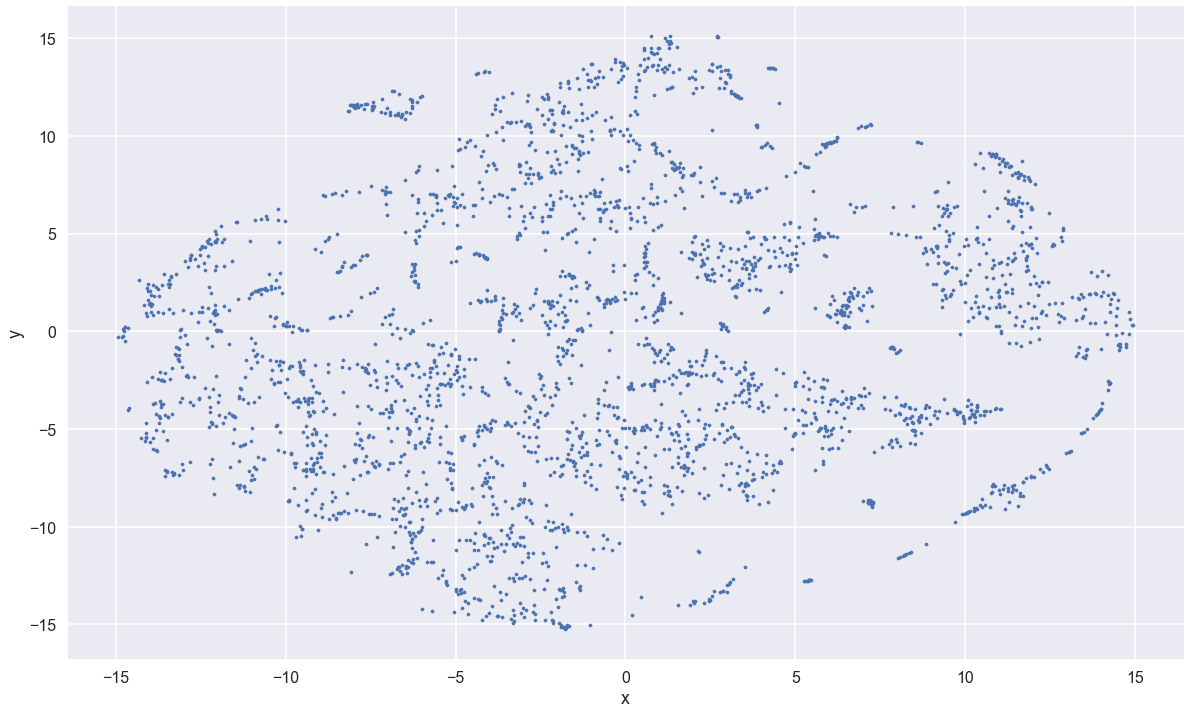

In [45]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [46]:
def plot_region(x_bounds, y_bounds):
    slc = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    ax = slc.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slc.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

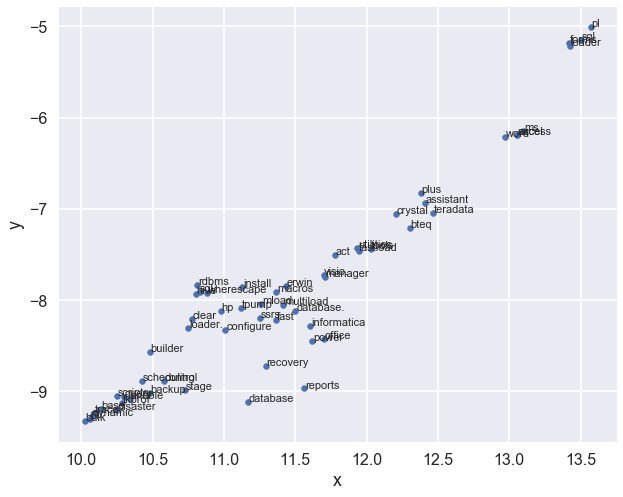

In [47]:
plot_region(x_bounds=(10, 15), y_bounds=(-10, -5))

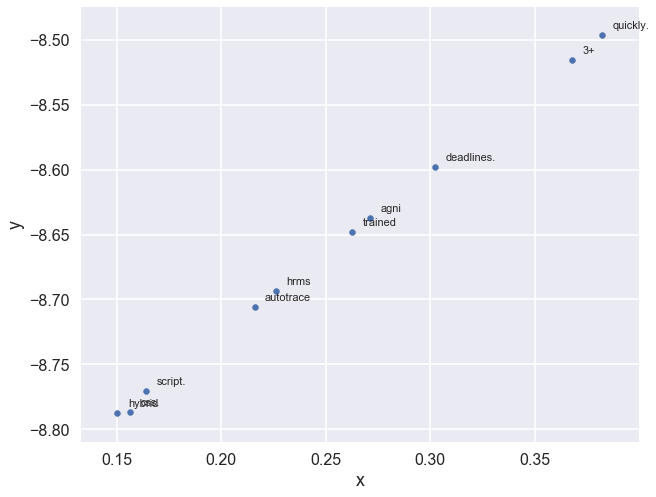

In [210]:
plot_region(x_bounds=(0,0.4), y_bounds=(-8.8,-8.4))